# Vegetarian Classifier

### Problem statement: Can we develop a classifier that can label someone as vegetarian or not?

### Data: Instacart's 3 million orders dataset, from Kaggle. https://www.kaggle.com/c/instacart-market-basket-analysis/data. The data does not label shoppers as vegetarian or not, so we'll have to label the data ourselves. We'll assume that if someone has purchased meat, then they are _not_ a vegetarian. (Of course, this is a huge assumption- someone who eats meat could easily buy their meat from a store that isn't included in this dataset).

### Implication of labelling data ourselves: We will have to exclude any meat purchases from our training data. If we didn't, then the classifier would learn to use only those purchases to label our shoppers as vegetarian or not. But this works well- we'll end up finding information in the data _other than_ explicit meat purchases (or absence of them) that imply that someone is vegetarian.

# Imports, garbage collection

In [1]:
import gc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
from IPython.core.interactiveshell import InteractiveShell
%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"
colour = sns.color_palette()
warnings.filterwarnings('ignore')
gc.collect()

0

# Read in Instacart data

In [2]:
### Define column names, and column datatypes. ###
prod_cols = ['product_id','product_name','aisle_id','department_id']
prod_dtypes= {'product_id':str,'product_name':str,'aisle_id':str,'department_id':str}
order_cols = ['order_id','user_id','eval_set','order_number','order_dow',
              'order_hour_of_day','days_since_prior_order']
order_dtypes = {'order_id':str,'user_id':str,'eval_set':str,'order_number':str,
                'order_dow':str,'order_hour_of_day':str,'days_since_prior_order':str}
order_prods_cols = ['order_id','product_id','add_to_cart_order','reordered']
order_prods_dtypes = {'order_id':str,'product_id':str,'add_to_cart_order':str,'reordered':str}
department_names = ["department_id", "department"]
department_dtypes = {"department_id":str, "department":str}
aisle_names = ["aisle_id", "aisle"]
aisle_dtypes = {"aisle_id":str, "aisle":str}

### Paths to the various files ###
prod_path = '/home/serena/workspace/Jupyter/Instacart/products.csv'
order_path = '/home/serena/workspace/Jupyter/Instacart/orders.csv'
order_prods_path = '/home/serena/workspace/Jupyter/Instacart/order_products__train.csv'
order_prods_prior_path = '/home/serena/workspace/Jupyter/Instacart/order_products__prior.csv'
department_path = '/home/serena/workspace/Jupyter/Instacart/departments/departments.csv'
aisle_path = '/home/serena/workspace/Jupyter/Instacart/aisles/aisles.csv'

### Read the files to dataframes ###
prods = pd.read_csv(prod_path, names=prod_cols, dtype=prod_dtypes, na_filter=False)
orders = pd.read_csv(order_path, names=order_cols, dtype=order_dtypes, na_filter=False)
order_prods = pd.read_csv(order_prods_path, names=order_prods_cols, dtype=order_prods_dtypes, na_filter=False)
order_prods_prior = pd.read_csv(order_prods_prior_path, names=order_prods_cols, dtype=order_prods_dtypes, na_filter=False)
departments = pd.read_csv(department_path, names=department_names, dtype=department_dtypes)
prods = prods.iloc[1:]
orders = orders.iloc[1:]
order_prods = order_prods.iloc[1:]
order_prods_prior = order_prods_prior.iloc[1:]
departments = departments.iloc[1:]
# Combine order_prods and order_prods_prior
# order_prods contains the most recent orders for a shopper
# order_prods_prior contains earlier orders
order_prods_all = pd.concat([order_prods, order_prods_prior], axis=0)

### View the first rows of each file ###
orders.head()
prods.head()
order_prods.head()
order_prods_prior.head()

order_id user_id eval_set order_number order_dow order_hour_of_day  \
1  2539329       1    prior            1         2                08   
2  2398795       1    prior            2         3                07   
3   473747       1    prior            3         3                12   
4  2254736       1    prior            4         4                07   
5   431534       1    prior            5         4                15   

  days_since_prior_order  
1                         
2                   15.0  
3                   21.0  
4                   29.0  
5                   28.0

product_id                                       product_name aisle_id  \
1          1                         Chocolate Sandwich Cookies       61   
2          2                                   All-Seasons Salt      104   
3          3               Robust Golden Unsweetened Oolong Tea       94   
4          4  Smart Ones Classic Favorites Mini Rigatoni Wit...       38   
5          5                          Green Chile Anytime Sauce        5   

  department_id  
1            19  
2            13  
3             7  
4             1  
5            13

order_id product_id add_to_cart_order reordered
1        1      49302                 1         1
2        1      11109                 2         1
3        1      10246                 3         0
4        1      49683                 4         0
5        1      43633                 5         1

order_id product_id add_to_cart_order reordered
1        2      33120                 1         1
2        2      28985                 2         1
3        2       9327                 3         0
4        2      45918                 4         1
5        2      30035                 5         0

#### We want to identify shoppers who are vegetarian. The product information we get is product_id, product_name, aisle_id, and department_id. The first step is then to identify what meat-centric departments exist in the Instacart data. 

In [3]:
### View the departments dataframe.###
departments

department_id       department
1              1           frozen
2              2            other
3              3           bakery
4              4          produce
5              5          alcohol
6              6    international
7              7        beverages
8              8             pets
9              9  dry goods pasta
10            10             bulk
11            11    personal care
12            12     meat seafood
13            13           pantry
14            14        breakfast
15            15     canned goods
16            16       dairy eggs
17            17        household
18            18           babies
19            19           snacks
20            20             deli
21            21          missing

#### We can identify department 12, "meat seafood" as the meat department. We'll assume that if shoppers have purchased from department 12, then they're not vegetarian. Shoppers who _have not_ purchased from department 12 will be assumed to be vegetarian.

In [4]:
### Size of the tables: (number of rows, number of columns) ###
# E.g. order_prods has 1384618 rows, and 4 columns: order_id, product_id, add_to_cart_order, reordered
print("The order_prods size is : ", order_prods.shape)
print("The order_prods_prior size is : ", order_prods_prior.shape)
print("The order_products_all size is : ", order_prods_all.shape)

The order_prods size is :  (1384617, 4)
The order_prods_prior size is :  (32434489, 4)
The order_products_all size is :  (33819106, 4)


#### This notebook is being run locally, so let's try to keep the size of the data small if we can. Let's use order_prods_prior since it has less orders than order_products_all, but still more than just a shopper's most recent orders (order_prods). Let's join the order_prods_prior and orders tables together, so that we get a shopper's history (order_prods_prior) along with specific order information (like day of week). We'll also need to join the prods table to these two, so that we can get department_id's and identify the shoppers who are vegetarian.

In [5]:
order_data = order_prods_prior.merge(prods, on = "product_id", how = "left")
final_order_data = order_data.merge(orders, on = "order_id", how = "left")
final_order_data.head()

order_id product_id add_to_cart_order reordered           product_name  \
0        2      33120                 1         1     Organic Egg Whites   
1        2      28985                 2         1  Michigan Organic Kale   
2        2       9327                 3         0          Garlic Powder   
3        2      45918                 4         1         Coconut Butter   
4        2      30035                 5         0      Natural Sweetener   

  aisle_id department_id user_id eval_set order_number order_dow  \
0       86            16  202279    prior            3         5   
1       83             4  202279    prior            3         5   
2      104            13  202279    prior            3         5   
3       19            13  202279    prior            3         5   
4       17            13  202279    prior            3         5   

  order_hour_of_day days_since_prior_order  
0                09                    8.0  
1                09                    8.0  
2                09                    8.0  
3                09                    8.0  
4                09                    8.0

In [6]:
### Count the number of vegetarians. ###
# First look at "not vegetarians"- these are people who have purchased from the meat seafood category.
not_vegetarians = list(final_order_data[final_order_data.department_id == "12"].user_id.unique())
print("There are %s shoppers who have purchased meat or seafood." %len(not_vegetarians))
print("So there are %s shoppers who are vegetarian." % (final_order_data.user_id.nunique()- len(not_vegetarians)))
print("As a reminder, there are %s shoppers in the database." %final_order_data.user_id.nunique())

There are 113891 shoppers who have purchased meat or seafood.
So there are 92318 shoppers who are vegetarian.
As a reminder, there are 206209 shoppers in the database.


In [7]:
### Create veg column. ###
final_order_data["veg"] = np.where(final_order_data["user_id"].isin(not_vegetarians), 0, 1)
### Convert values to numeric ##
final_order_data["order_dow"] = pd.to_numeric(final_order_data["order_dow"])
final_order_data["order_hour_of_day"] = pd.to_numeric(final_order_data["order_hour_of_day"])
final_order_data["order_number"] = pd.to_numeric(final_order_data["order_number"])
final_order_data["days_since_prior_order"] = pd.to_numeric(final_order_data["days_since_prior_order"])
final_order_data["add_to_cart_order"] = pd.to_numeric(final_order_data["days_since_prior_order"])
final_order_data["reordered"] = pd.to_numeric(final_order_data["reordered"])
final_order_data.head()

order_id product_id  add_to_cart_order  reordered           product_name  \
0        2      33120                8.0          1     Organic Egg Whites   
1        2      28985                8.0          1  Michigan Organic Kale   
2        2       9327                8.0          0          Garlic Powder   
3        2      45918                8.0          1         Coconut Butter   
4        2      30035                8.0          0      Natural Sweetener   

  aisle_id department_id user_id eval_set  order_number  order_dow  \
0       86            16  202279    prior             3          5   
1       83             4  202279    prior             3          5   
2      104            13  202279    prior             3          5   
3       19            13  202279    prior             3          5   
4       17            13  202279    prior             3          5   

   order_hour_of_day  days_since_prior_order  veg  
0                  9                     8.0    1  
1                  9                     8.0    1  
2                  9                     8.0    1  
3                  9                     8.0    1  
4                  9                     8.0    1

# EDA: Group specific features.

## Let's do some exploratory data analysis to try to understand the differences between vegetarians vs non-vegetarians.

## Number of purchases per day of week, per group.

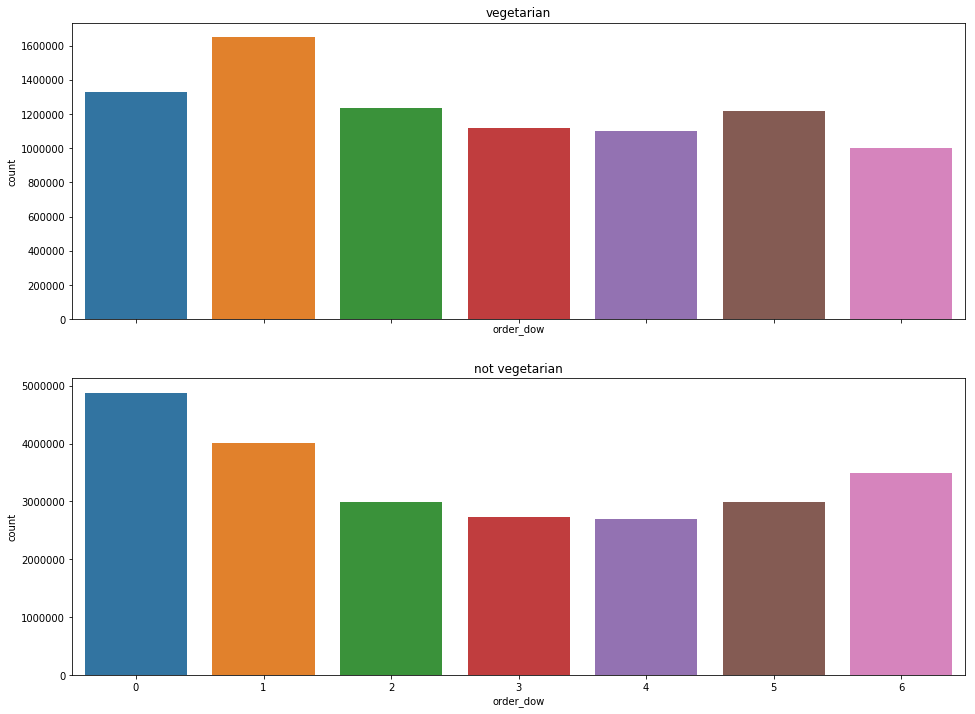

<Figure size 1440x576 with 0 Axes>

In [8]:
def count_plot(data, col):
    f, axes = plt.subplots(2, 1, figsize=(16,12), sharex=True)
    plt.figure(figsize=(20,8))
    g1 = sns.countplot(x=col, data=data[data.veg==1], ax=axes[0])
    g1.set_title("vegetarian")
    g2 = sns.countplot(x=col, data=data[data.veg==0], ax=axes[1])
    g2.set_title("not vegetarian")
    plt.tight_layout()
    
count_plot(final_order_data, "order_dow")

#### In the plots above, it's not entirely clear what day is which (Instacart didn't specify this in the Kaggle competition).

#### You can see that there is a difference between vegetarians and non-vegetarians- vegetarians seem to shop mostly on day 1, which is unique to this group.

## Histogram of  order hour of day per group.

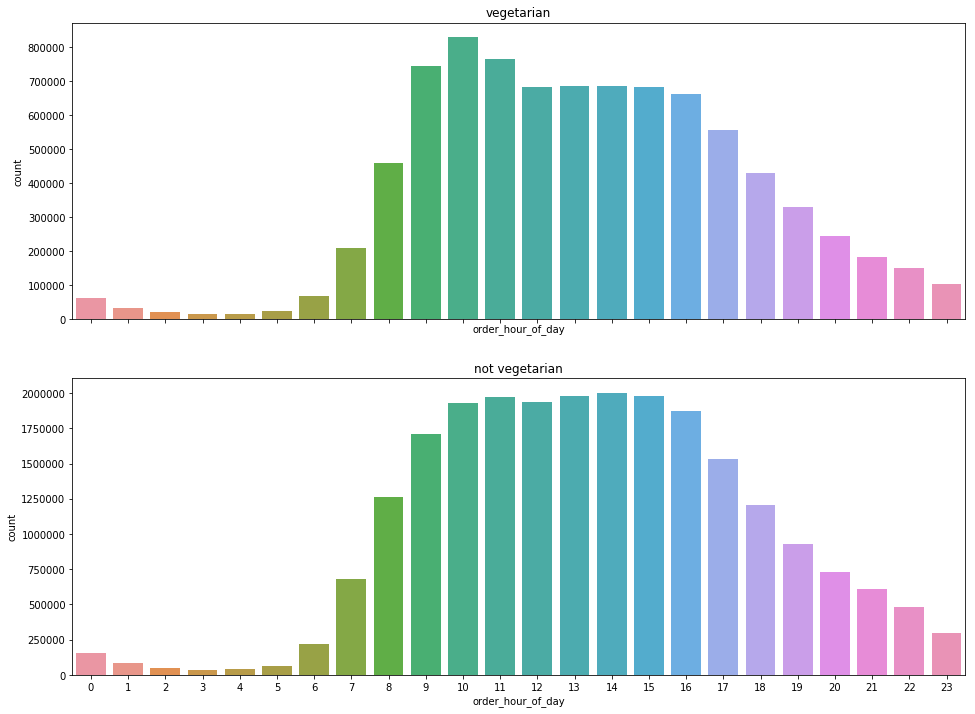

<Figure size 1440x576 with 0 Axes>

In [9]:
count_plot(final_order_data, "order_hour_of_day")

#### We can see that there is a slight difference in behaviour of shoppers who are vegetarian vs those who are not. The vegetarian distribution has a spike in shopping in the morning, compared to all other shoppers.


## Distribution of days since prior order of each group.

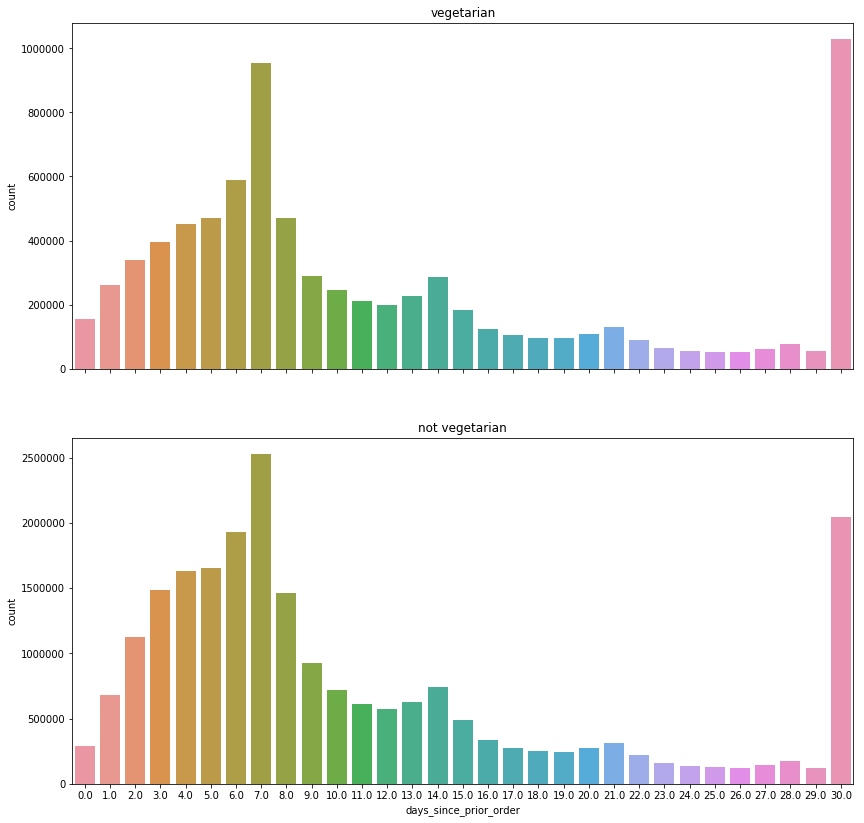

<Figure size 1440x576 with 0 Axes>

In [10]:
def count_plot_dist(data,col):
    f, axes = plt.subplots(2, 1, figsize=(14,14), sharex=True)
    plt.figure(figsize=(20,8))
    g1 = sns.countplot(x=col, data=data[data.veg==1], ax=axes[0])
    g1.set_title("vegetarian")
    g1.set_xlabel('')
    g2 = sns.countplot(x=col, data=data[data.veg==0], ax=axes[1])
    g2.set_title("not vegetarian")
    plt.tight_layout()

count_plot_dist(final_order_data,"days_since_prior_order")

#### The number of days since a shopper's prior order shows a distribution with spikes at 7 days, 14 days, 21 days, and 30 days since a previous order, for both groups. That implies that people tend to shop weekly- so someone may choose to do their shopping on Sundays, while another shopper may choose to shop on Wednesdays. I assume the spike on the right hand side is because if any shopper has more than 30 days between orders, it's set to 30.

#### If we focus on the "not veg" group vs the "veg" group, we see that there is a slight difference between the two.

## Heat map of order hour of day vs order day of week- this lets us see the most frequent values.

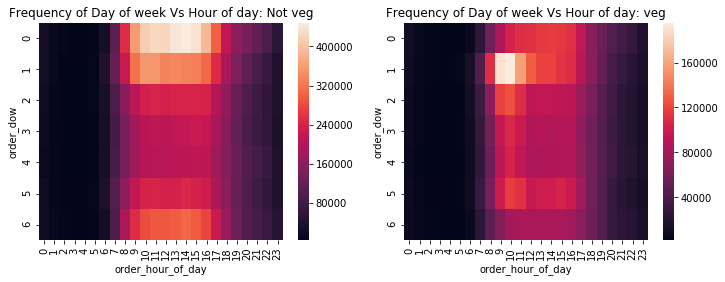

<Figure size 1152x576 with 0 Axes>

In [11]:
# Heatmap of day of week vs hour of day
def dow_vs_hour(data):
    group="veg"
    grouped_df0 = data[data[group]==0].groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
    grouped_df0 = grouped_df0.pivot('order_dow', 'order_hour_of_day', 'order_number')
    grouped_df1 = data[data[group]==1].groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
    grouped_df1 = grouped_df1.pivot('order_dow', 'order_hour_of_day', 'order_number')    
    f, axes = plt.subplots(1, 2, figsize=(12,4), sharex=True)
    plt.figure(figsize=(16,8))    
    g0 = sns.heatmap(grouped_df0,ax=axes[0])
    g0.set_title("Frequency of Day of week Vs Hour of day: Not {}".format(group))
    g1 = sns.heatmap(grouped_df1,ax=axes[1])
    g1.set_title("Frequency of Day of week Vs Hour of day: {}".format(group))
    plt.tight_layout()
    plt.show()
    
dow_vs_hour(final_order_data)

#### It seems that vegetarians show a high affinity for shopping around 9/10 am on Day 0 and 1.

#### The results imply that order hour of day and order day of week are possible factors that can differentiate people in binary segments.

## Purchase count per department, for each group.

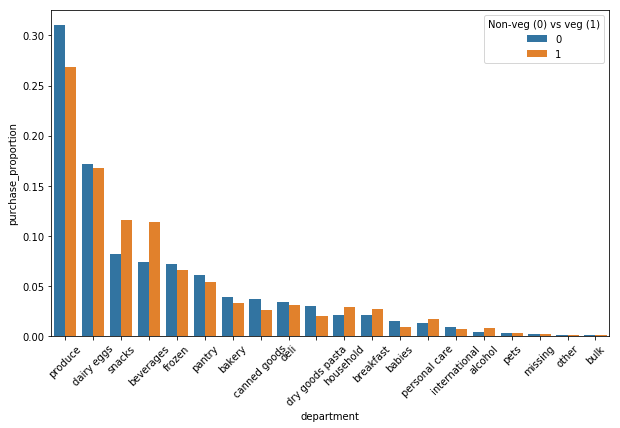

In [12]:
def proportion_plot_both_groups(data):
    group="veg"
    data = data[data.department!="meat seafood"] 
    x, y, hue = "department", "purchase_proportion", group
    hue_order = [group, "not_{}".format(group)]
    plt.figure(figsize=(10,6))
    (data[x]
     .groupby(data[hue])
     .value_counts(normalize=True)
     .rename(y)
     .reset_index()
     .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))
    plt.xticks(rotation='45')
    l = plt.legend(loc="upper right")
    l.set_title('Non-{group} (0) vs {group} (1)'.format(group=group))

merged_data = final_order_data.merge(departments, on = "department_id")
proportion_plot_both_groups(merged_data)

#### Here we care about the distribution of the two groups relative to each other, rather than the actual purchase counts. If the distributions are different then we can assume that purchase count per department is a feature that differentiates the vegetarian and non-vegetarian groups. We can't really see much of a difference here- the distributions are a bit different but nothing huge- so that seems to imply that this feature may not be hugely important.

# Reordering tendencies vegetarians vs non vegetarians.

#### Department reorder ratio is the ratio of how many times a group reorders from a certain department, versus how often they do not reorder (reorder a new item). For example, a 0.55 department reorder ratio for vegetarians for department A would mean that 55% of a vegetarians' orders from department A are items they are reordering.

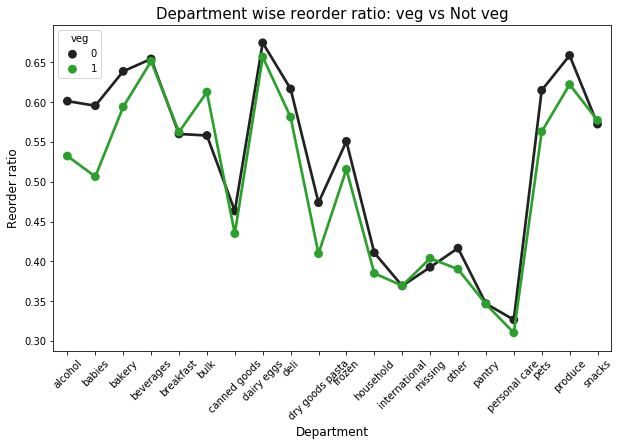

In [13]:
def reorders_plot_both_groups(data):
    group="veg"  
    data = data[data.department!="meat seafood"] 
    plot_title="Department wise reorder ratio: {group} vs Not {group}".format(group=group)
    grouped_df = data.groupby(["department",group])["reordered"].aggregate("mean").reset_index()
    plt.figure(figsize=(10,6))
    sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, 
                  alpha=0.8, color=colour[2], hue=grouped_df[group])
    plt.ylabel('Reorder ratio', fontsize=12)
    plt.xlabel('Department', fontsize=12)
    plt.title(plot_title, fontsize=15)
    plt.xticks(rotation='45')
    plt.show()

reorders_plot_both_groups(merged_data)

#### It appears that vegetarians re-order bulk foods more than non-vegetarians. Department reorder ratio may be an important feature in differentiating vegetarians and non-vegetarians

# Reorder tendencies and day of week.

#### Day of week reorder ratio is how often a group reorders items on a particular day of week, versus how much they do not reorder (order a new item).

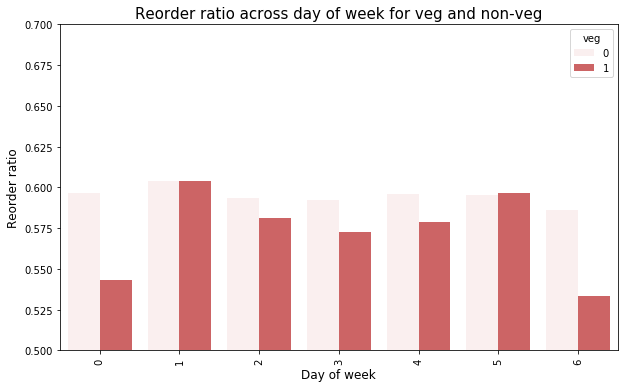

In [14]:
def reorders_dow_both_groups(data):
    group="veg"
    plot_title = "Reorder ratio across day of week for {group} and non-{group}".format(group=group)
    grouped_df = data.groupby(["order_dow", group])["reordered"].aggregate("mean").reset_index()
    plt.figure(figsize=(10,6))
    sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, 
                alpha=0.8, color=colour[3], hue=grouped_df[group])
    plt.ylabel('Reorder ratio', fontsize=12)
    plt.xlabel('Day of week', fontsize=12)
    plt.title(plot_title, fontsize=15)
    plt.xticks(rotation='vertical')
    plt.ylim(0.5, 0.7)
    plt.show()

reorders_dow_both_groups(final_order_data)

#### It apears that vegetarian reorder rate is lower on the weekends compared to non-vegetarians who reorder at fairly consistent rates regardless of day of the week. That's interesting- reorder ratio per day of week could be a meaningful feature for the model.

# EDA: Department x User Features

In [19]:
def plot_correlations(feature_df, col_prefix):
    group = "veg"
    to_drop = "{}_12".format(col_prefix)
    feature_df = feature_df.drop(to_drop, axis=1)
    plot_title = "Correlation matrix (Pearson) for the {group} group.".format(group=group)
    labels = final_order_data[["user_id", group]].drop_duplicates()
    labels=labels[labels[group]==1]
    df = feature_df.merge(labels,on="user_id")
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 8))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(plot_title, fontsize=15)
    
def plot_group_proportions(feature_df, order_data, col, n, format_xticks):
    group = "veg"
    data = feature_df.merge(order_data[["user_id", group]].drop_duplicates(), on = "user_id")
    x, y, hue = col, "purchase_proportion", group
    hue_order = [group, "not_{}".format(group)]
    plt.figure(figsize=(12,6))
    (data[x]
     .groupby(data[hue])
     .value_counts(normalize=True)
     .rename(y)
     .reset_index()
     .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))
    plt.xticks(rotation='45')
    ax = plt.gca()
    if format_xticks is True:
        for index, label in enumerate(ax.xaxis.get_ticklabels()):
            if index % n != 0:
                label.set_visible(False)
    l = plt.legend(loc="upper right")
    l.set_title('Non-{group} (0) vs {group} (1)'.format(group=group))
    
def feature_correlation(f1, f2):
    feature = f1.merge(f2, on = "user_id")
    corr = feature.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})    

def get_dept_reorder_rate(data):
    dept_reorder_rate = data.groupby(["user_id", "department_id"])["reordered"].aggregate("mean").reset_index(name="reorder_rate")
    dept_reorder_rate = dept_reorder_rate.pivot_table(index='user_id', columns='department_id', values='reorder_rate')
    dept_reorder_rate.fillna(0, inplace=True)
    dept_reorder_rate.columns = ['reord_rt_dept_' + str(col) for col in dept_reorder_rate.columns]
    return dept_reorder_rate

def get_num_dept_reorders(data):
    dept_num_reorders = data.groupby(["user_id", "department_id"])["reordered"].aggregate("sum").reset_index(name="num_reorders")
    dept_num_reorders = dept_num_reorders.pivot_table(index='user_id', columns='department_id', values='num_reorders')
    dept_num_reorders.fillna(0, inplace=True)
    dept_num_reorders.columns = ['num_reorder_dept_' + str(col) for col in dept_num_reorders.columns]
    return dept_num_reorders

def get_time_bw_dept_purchases(data):
    avg_time_bw_dept = data.groupby(["user_id","department_id"])["days_since_prior_order"].aggregate("mean").reset_index(name="avg_days_bw_order_dept")
    avg_time_bw_dept["avg_days_bw_order_dept"] = round(avg_time_bw_dept["avg_days_bw_order_dept"],1)
    avg_time_bw_dept = avg_time_bw_dept.pivot_table(index='user_id', columns='department_id', values='avg_days_bw_order_dept')
    avg_time_bw_dept.fillna(0, inplace=True)
    avg_time_bw_dept.columns = ['avg_days_bw_dept_' + str(col) for col in avg_time_bw_dept.columns]
    return avg_time_bw_dept

## Number of times purchased from each department: correlation between departments

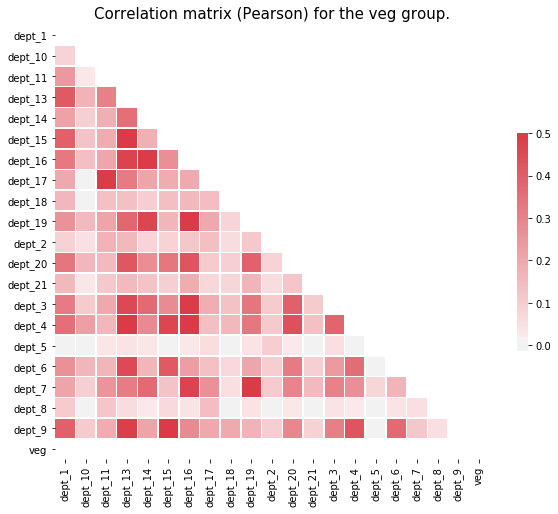

In [18]:
def get_num_dept_purchases(data):
    num_dept_purchases = data.groupby(["user_id", "department_id"]).size().reset_index(name="num_orders")
    num_dept_purchases = num_dept_purchases.pivot_table(index='user_id', columns='department_id', values='num_orders')
    num_dept_purchases.fillna(0, inplace=True)
    num_dept_purchases.columns = ['dept_' + str(col) for col in num_dept_purchases.columns]
    # Drop the columns that were used to define the segments
    # We don't need to see them in the correlation plot
    return num_dept_purchases

num_dept_purchases = get_num_dept_purchases(final_order_data) # Feature
plot_correlations(num_dept_purchases, "dept")

#### We can see from the correlation matrix the some of the features (number of times purchased from each individual department) is correlated. This implies that some of these features may be dropped. For example, dept 9 and dept 1 are highly correlated (see the bottom left corner), so this means we could use either dept_1 or dept_9 as a feature, and could throw out one of them.

## Number of unique department purchases

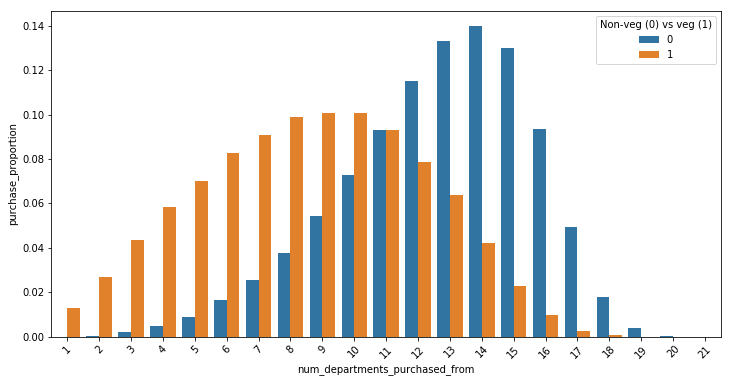

In [24]:
def get_num_unique_dept_purchases(data):
    num_unique_dept = data.groupby(["user_id"])["department"].aggregate("nunique").reset_index()
    num_unique_dept.columns = ["user_id", "num_departments_purchased_from"]
    return num_unique_dept

num_unique_dept = get_num_unique_dept_purchases(merged_data) # Feature
plot_group_proportions(num_unique_dept, final_order_data, "num_departments_purchased_from", 0, False)

#### From the plots above we can see that the number of unique departments purchased from differs in distribution for shoppers in the vegetarian/not groups. This implies that this feature could be useful for our model.

## User's department re-order rate: i.e. proportion of orders from that department that are re-orders: correlation between departments

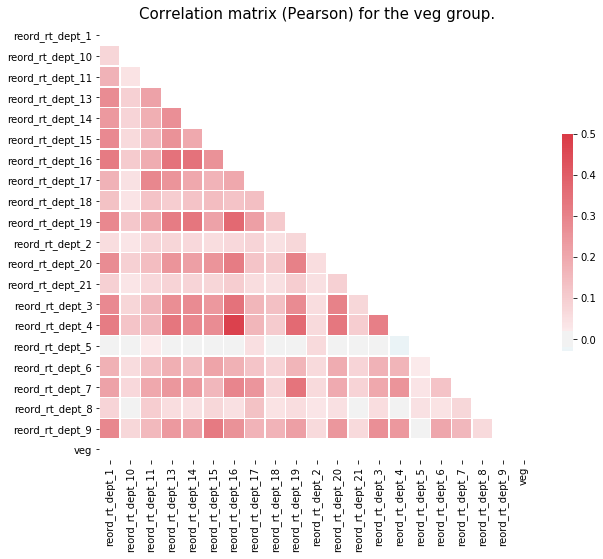

In [25]:
dept_reorder_rate = get_dept_reorder_rate(merged_data) # Feature
plot_correlations(dept_reorder_rate,"reord_rt_dept")

#### Again, we see some correlation, but nothing too strong.

## Number of times reordered from department

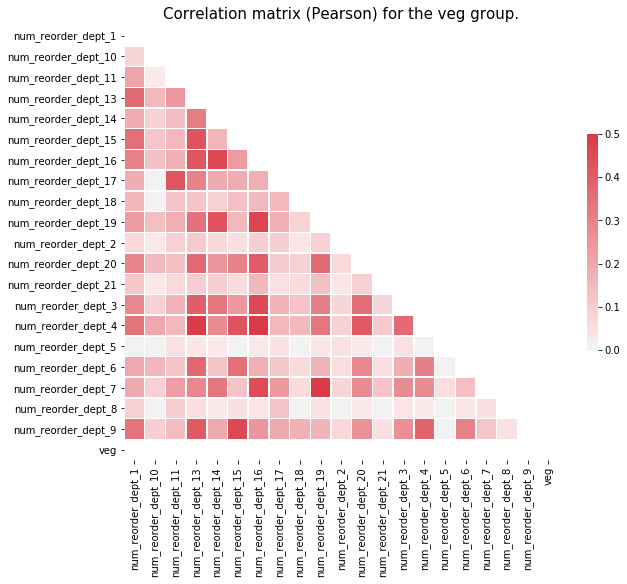

In [32]:
num_dept_reorders = get_num_dept_reorders(merged_data) # Feature
plot_correlations(num_dept_reorders,"num_reorder_dept")

#### Again, we don't see much interesting information, other than we can probably drop some of the features due to correlated variables.

## Correlation of number of departments purchased from, and department reorder rate.

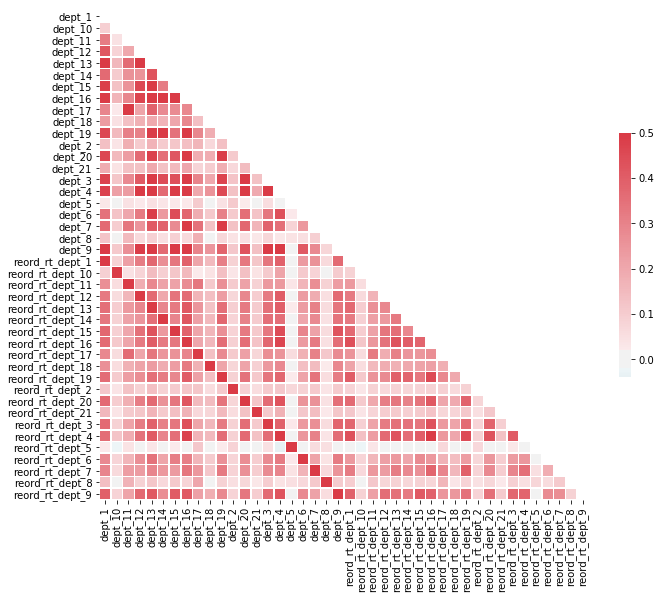

In [33]:
feature_correlation(num_dept_purchases, dept_reorder_rate)

#### The dark red diagonal line is what we're interested in. This implies that the "reorder rate" and "number of times purchased from each department" variables are highly correlated. So that implies that we can use just one of the two types of features. That'll reduce our feature space greatly (since each type of feature products a feature for each department). 

## Correlation of number of departments purchased from, and number of department reorders.

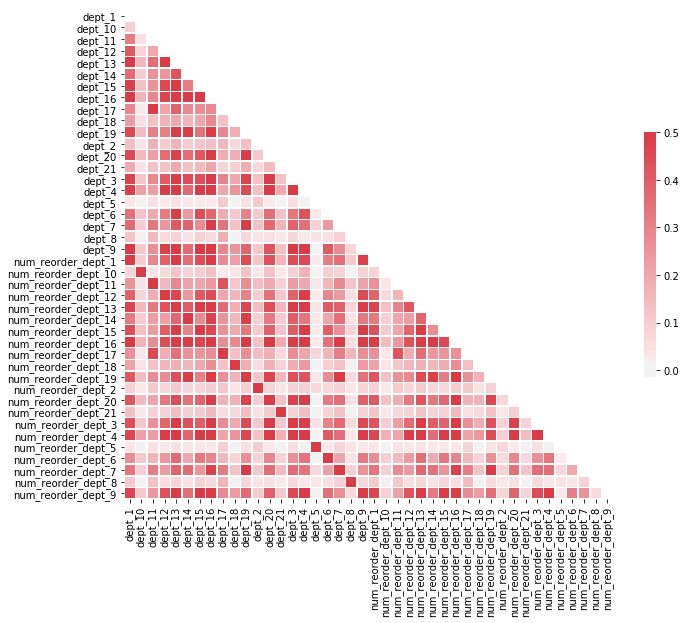

In [34]:
feature_correlation(num_dept_purchases, num_dept_reorders)

#### As expected, we see fairly high correlation values. 

## Average time betwen purchase per department

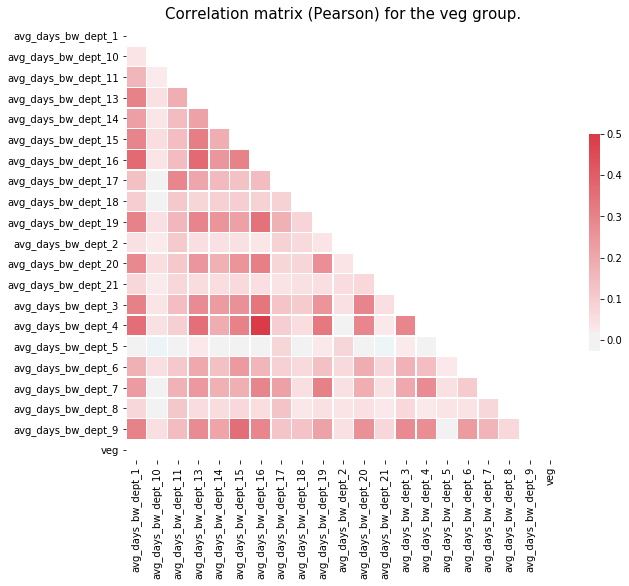

In [35]:
time_bw_dept_purchases = get_time_bw_dept_purchases(merged_data) # Feature #get time bw dept purcahses
plot_correlations(time_bw_dept_purchases, "avg_days_bw_dept")

#### We can see that average time between department purchases could be useful. There's some correlation between departments.

## Correlation between average time between department purchase and department reorder rate.

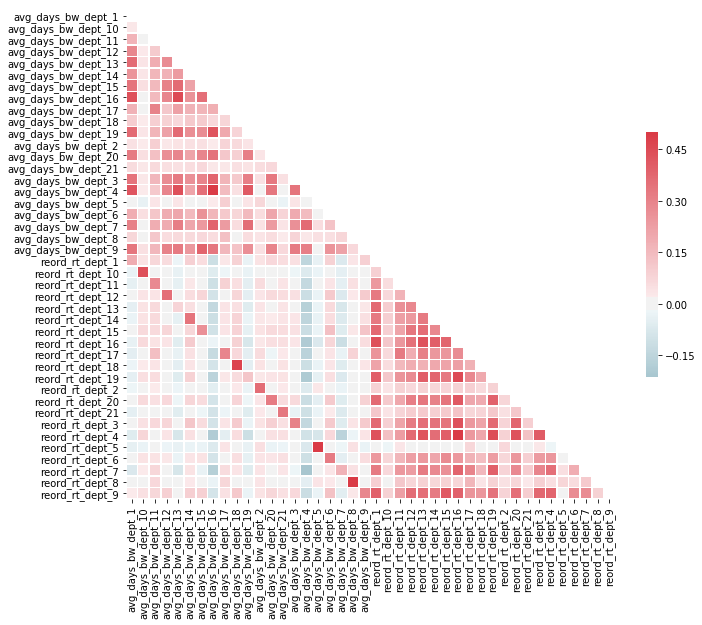

In [36]:
feature_correlation(time_bw_dept_purchases, dept_reorder_rate)

#### We see a weaker correlation between avg time between department reorders and department reorder rate.

# User-based features

In [37]:
def get_time_bw_orders(data):
    avg_time_bw = data.groupby(["user_id"])["days_since_prior_order"].aggregate("mean").reset_index(name="avg_days_bw_order")
    avg_time_bw["avg_days_bw_order"] = round(avg_time_bw["avg_days_bw_order"])
    return avg_time_bw

def get_avg_tod(data):
    avg_tod = data.groupby(["user_id"])["order_hour_of_day"].aggregate("mean").reset_index(name="avg_tod")
    avg_tod["avg_tod"] = round(avg_tod["avg_tod"],1)
    return avg_tod
    
def get_avg_dow(data):
    avg_dow = final_order_data.groupby(["user_id"])["order_dow"].aggregate("mean").reset_index(name="avg_dow")
    avg_dow["avg_dow"] = round(avg_dow["avg_dow"],1)
    return avg_dow

# Add to cart order is a way to get the number of items in the basket
# Max "add_to_cart_order" is the total number of items
def get_num_items_basket(data):
    add_to_cart_info = data.groupby(["user_id", "order_id"])["add_to_cart_order"].aggregate("max").reset_index(name="num_items")
    avg_order_size = add_to_cart_info.groupby(["user_id"])["num_items"].aggregate("mean").reset_index(name="avg_num_items")
    avg_order_size["avg_num_items"] = round(avg_order_size["avg_num_items"],1)
    return avg_order_size

def get_order_size_std(data):
    add_to_cart_info = data.groupby(["user_id", "order_id"])["add_to_cart_order"].aggregate("max").reset_index(name="num_items")
    std_order_size = add_to_cart_info.groupby(["user_id"])["num_items"].aggregate("std").reset_index(name="std_num_items")
    std_order_size["std_num_items"] = round(std_order_size["std_num_items"],1)
    return std_order_size

def get_user_reorder_rate(data):
    user_reorder_rate = data.groupby(["user_id"])["reordered"].aggregate("mean").reset_index(name="user_reorder_rate")
    user_reorder_rate["user_reorder_rate"] = round(user_reorder_rate["user_reorder_rate"],2)
    return user_reorder_rate

### Average time between orders

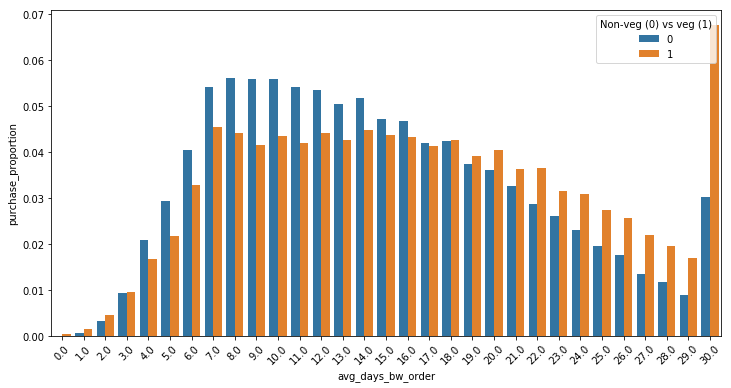

In [38]:
avg_time_bw = get_time_bw_orders(merged_data)
plot_group_proportions(avg_time_bw, final_order_data, "avg_days_bw_order", 0, False)

#### We can see that the distribution for vegetarians vs non-vegetarians differs.

### Average time of day of user visit

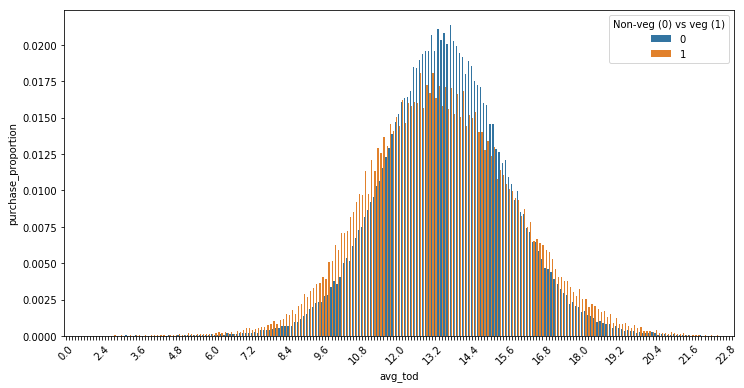

In [39]:
avg_tod = get_avg_tod(merged_data)
plot_group_proportions(avg_tod, final_order_data, "avg_tod", 12, True)

#### Again, distribution differs largely between vegetarians and non/vegetarians, and slightly but less so between parents and non-parents.

### Average day of week of visit

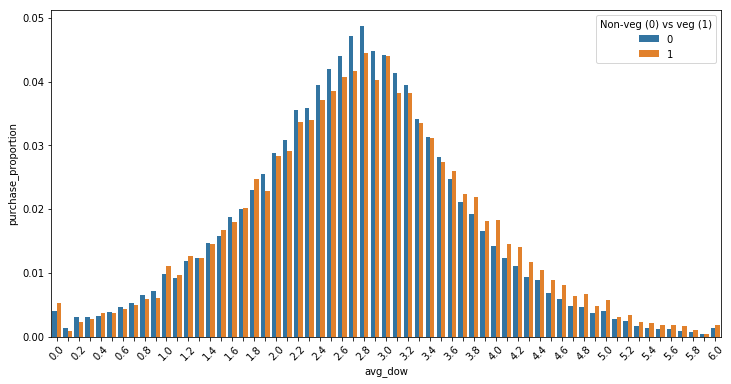

In [40]:
avg_dow = get_avg_dow(merged_data)
plot_group_proportions(avg_dow, final_order_data, "avg_dow", 2, True)

#### Again, slight different between the groups, but really not much.

### Average order size - using add to cart order as the number of items- should check this assumption

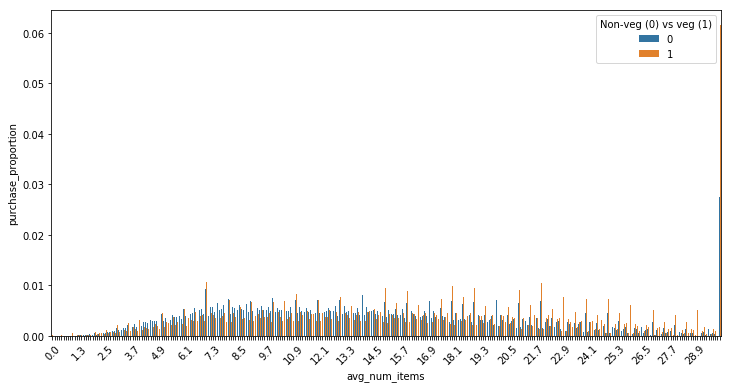

In [41]:
avg_order_size = get_num_items_basket(merged_data)
plot_group_proportions(avg_order_size, final_order_data, "avg_num_items", 12, True)

#### There's a fairly large difference between vegetarians and non-vegetarians.

## Standard deviation of order size- we want to look at a shopper's order size variation. We _could_ create 2 features: max order size, and min order size, but standard deviation could capture what we're looking for.

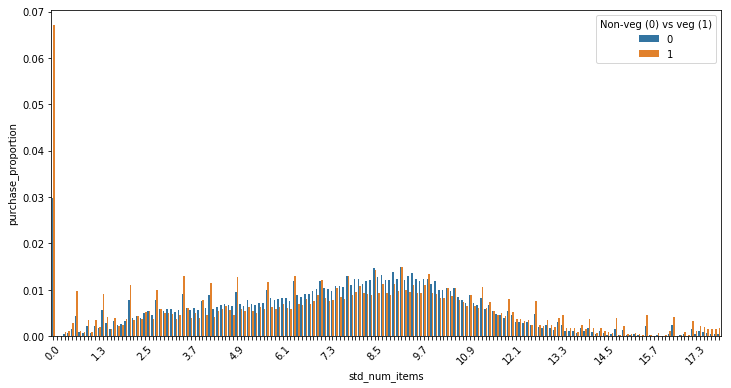

In [42]:
std_order_size = get_order_size_std(merged_data)
plot_group_proportions(std_order_size, final_order_data, "std_num_items", 12, True)

#### We can't really tell too much about distribution differences between the groups.

## User's individual reorder rate (across all departments) ie percentage of orders that are reorders

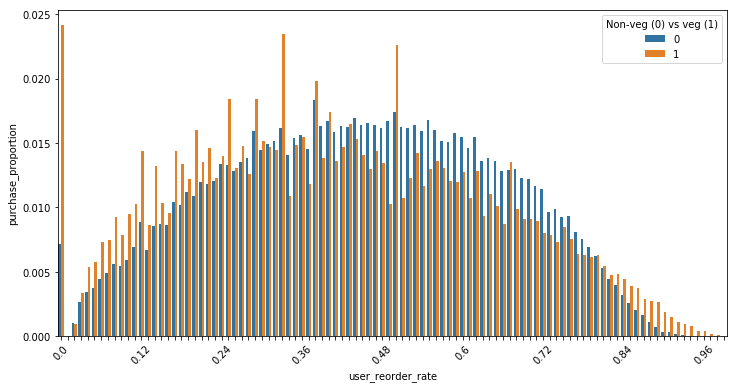

In [43]:
user_reorder_rate = get_user_reorder_rate(merged_data)
plot_group_proportions(user_reorder_rate, final_order_data, "user_reorder_rate", 12, True)

#### Looking at the figure above, you can see that user reorder rate distribution does vary depending on group.

# Quick prototype of a vegetarian classification model
### Features:

1. num_dept_purchases
2. num_unique_dept --> good
3. dept_reorder_rate
4. dept_num_reorders
5. avg_time_bw
6. avg_tod
7. avg_dow
8. avg_order_size
9. std_order_size
10. avg_time_bw_dept
11. user_reorder_rate

Let's use 1,2,5,6,7,8,9, 10, and 11. 1, 3, 4 are all showed some degree of correlation with each other. If I cared to put more effort into this, I would take more time into investigating the relationships between variables.

### Step 1. Merge all the data into one dataframe, and take a look at the first few rows.

In [44]:
# Merge all the features into one dataframe
model_data = num_dept_purchases.merge(
    num_unique_dept, on ="user_id").merge(
    avg_time_bw, on = "user_id").merge(
    avg_tod, on = "user_id").merge(
    avg_dow, on = "user_id").merge(
    avg_order_size, on = "user_id").merge(
    std_order_size, on = "user_id").merge(
    time_bw_dept_purchases, on = "user_id").merge(
    user_reorder_rate, on = "user_id")

model_data = model_data.merge(
    final_order_data[["user_id", "veg"]].drop_duplicates(), on = "user_id")

# Take a look at the data
model_data.head()
model_data.columns

user_id  dept_1  dept_10  dept_11  dept_12  dept_13  dept_14  dept_15  \
0       1     0.0      0.0      0.0      0.0      1.0      3.0      0.0   
1      10     1.0      0.0      0.0     13.0     22.0      0.0      2.0   
2     100     3.0      0.0      0.0      3.0      0.0      0.0      0.0   
3    1000     5.0      0.0      0.0      0.0      1.0      0.0      4.0   
4   10000    56.0      1.0      6.0     56.0    108.0     13.0     23.0   

   dept_16  dept_17 ...   avg_days_bw_dept_21  avg_days_bw_dept_3  \
0     13.0      2.0 ...                   0.0                 0.0   
1     16.0      0.0 ...                   0.0                 0.0   
2      2.0      0.0 ...                   0.0                28.0   
3     32.0      0.0 ...                   7.5                 6.0   
4    231.0     18.0 ...                   0.0                 4.9   

   avg_days_bw_dept_4  avg_days_bw_dept_5  avg_days_bw_dept_6  \
0                25.4                 0.0                 0.0   
1                19.4                 0.0                30.0   
2                24.8                 0.0                 0.0   
3                11.4                 0.0                 0.0   
4                 5.3                 0.0                 5.0   

   avg_days_bw_dept_7  avg_days_bw_dept_8  avg_days_bw_dept_9  \
0                18.3                 0.0                 0.0   
1                 0.0                 0.0                 0.0   
2                 0.0                 0.0                 0.0   
3                13.4                 0.0                 0.0   
4                 4.1                 0.0                 5.3   

   user_reorder_rate  veg  
0               0.69    1  
1               0.34    0  
2               0.26    0  
3               0.69    1  
4               0.77    0  

[5 rows x 51 columns]

Index(['user_id', 'dept_1', 'dept_10', 'dept_11', 'dept_12', 'dept_13',
       'dept_14', 'dept_15', 'dept_16', 'dept_17', 'dept_18', 'dept_19',
       'dept_2', 'dept_20', 'dept_21', 'dept_3', 'dept_4', 'dept_5', 'dept_6',
       'dept_7', 'dept_8', 'dept_9', 'num_departments_purchased_from',
       'avg_days_bw_order', 'avg_tod', 'avg_dow', 'avg_num_items',
       'std_num_items', 'avg_days_bw_dept_1', 'avg_days_bw_dept_10',
       'avg_days_bw_dept_11', 'avg_days_bw_dept_12', 'avg_days_bw_dept_13',
       'avg_days_bw_dept_14', 'avg_days_bw_dept_15', 'avg_days_bw_dept_16',
       'avg_days_bw_dept_17', 'avg_days_bw_dept_18', 'avg_days_bw_dept_19',
       'avg_days_bw_dept_2', 'avg_days_bw_dept_20', 'avg_days_bw_dept_21',
       'avg_days_bw_dept_3', 'avg_days_bw_dept_4', 'avg_days_bw_dept_5',
       'avg_days_bw_dept_6', 'avg_days_bw_dept_7', 'avg_days_bw_dept_8',
       'avg_days_bw_dept_9', 'user_reorder_rate', 'veg'],
      dtype='object')

### Step 2. Remove the "meat seafood" department (department 12) from the dataset. We remove it because we used this column to define if someone is a vegetarian or not. Leaving this column would result in the model learning this- it would learn that someone is a vegetarian if they have purchased from the meat seafood department. We want to uncover _other_ information in the data, so we'll remove any trace of this department.

In [45]:
model_data.drop("dept_12", inplace=True, axis=1)
model_data.drop("avg_days_bw_dept_12", inplace=True, axis=1)

### Step 3. Let's look at the distribution of data- do we have a balance dataset?

In [47]:
model_data[model_data.veg==1].user_id.nunique()
model_data[model_data.veg==0].user_id.nunique()
model_data[model_data.veg==1].user_id.nunique()/model_data.user_id.nunique()

92318

113891

0.4476914198701318

#### 44% of our shoppers are vegetarian (as defined by having _not_ bought from the meat/seafood category). This isn't horribly imbalanced, it's actually pretty fine. But to illustrate one way to rebalance an imbalanced dataset, let's pretend this is a horrible imbalance that we absolutely must fix.

### Step 3. Fix the imbalance. We have a decent amount of shoppers who are not vegetarian, so let's undersample. We have 92318 shoppers who are vegetarian, so we'll get that many shoppers who are not vegetarian.

In [51]:
# Fix this cell
num_veg = len(model_data[model_data['veg'] == 1])
veg_indices = model_data[model_data.veg == 0].index #indices of non veg
random_indices = np.random.choice(veg_indices, num_veg, replace=False) # get random indices of nonparents
veg_indices = model_data[model_data.veg == 1].index # get indices of veg
under_sample_indices = np.concatenate([veg_indices,random_indices])
under_sample = model_data.loc[under_sample_indices]
# New X and y
features = model_data.columns
X = under_sample[features.drop(["user_id","veg"])]
y = under_sample[["veg"]]
X.columns
print("We have %s features." %len(features))

Index(['dept_1', 'dept_10', 'dept_11', 'dept_13', 'dept_14', 'dept_15',
       'dept_16', 'dept_17', 'dept_18', 'dept_19', 'dept_2', 'dept_20',
       'dept_21', 'dept_3', 'dept_4', 'dept_5', 'dept_6', 'dept_7', 'dept_8',
       'dept_9', 'num_departments_purchased_from', 'avg_days_bw_order',
       'avg_tod', 'avg_dow', 'avg_num_items', 'std_num_items',
       'avg_days_bw_dept_1', 'avg_days_bw_dept_10', 'avg_days_bw_dept_11',
       'avg_days_bw_dept_13', 'avg_days_bw_dept_14', 'avg_days_bw_dept_15',
       'avg_days_bw_dept_16', 'avg_days_bw_dept_17', 'avg_days_bw_dept_18',
       'avg_days_bw_dept_19', 'avg_days_bw_dept_2', 'avg_days_bw_dept_20',
       'avg_days_bw_dept_21', 'avg_days_bw_dept_3', 'avg_days_bw_dept_4',
       'avg_days_bw_dept_5', 'avg_days_bw_dept_6', 'avg_days_bw_dept_7',
       'avg_days_bw_dept_8', 'avg_days_bw_dept_9', 'user_reorder_rate'],
      dtype='object')

We have 49 features.


### Step 4. Test-train split on the balanced dataset. We _should_ do cross validation (ie fit model to training set, tune parameters on cross validation set, then test on test set). 

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print("We have %s shoppers who are not veg in the train set." 
      %y_train[y_train.veg==0].index.nunique())
print("We have %s shoppers who are veg in the train set." 
      %y_train[y_train.veg==1].index.nunique())
print("We have %s shoppers who are not veg in the test set." 
      %y_test[y_test.veg==0].index.nunique())
print("We have %s shoppers who are veg in the test set." 
      %y_test[y_test.veg==1].index.nunique())

We have 61777 shoppers who are not veg in the train set.
We have 61929 shoppers who are veg in the train set.
We have 30541 shoppers who are not veg in the test set.
We have 30389 shoppers who are veg in the test set.


### Step 5. Do logistic regression. Or your model of choice.

In [57]:
# Helper functions
def inspect_df(predictions, y_test):
    true_vs_pred = np.hstack((predictions, y_test))
    true_df = pd.DataFrame(true_vs_pred)
    true_df.columns = ["Predicted", "Actual"]
    return true_df

def accuracy_stats(df):
    fn = len(true_vs_pred[(true_vs_pred.Predicted==0)&(true_vs_pred.Actual==1)])
    tn = len(true_vs_pred[(true_vs_pred.Predicted==0)&(true_vs_pred.Actual==0)])
    fp = len(true_vs_pred[(true_vs_pred.Predicted==1)&(true_vs_pred.Actual==0)])
    tp = len(true_vs_pred[(true_vs_pred.Predicted==1)&(true_vs_pred.Actual==1)])
    print("There are %s false positives."%fp)
    print("There are %s false negatives."%fn)
    print("There are %s true positives."%tp)
    print("There are %s true negatives."%tn)
    return fp, fn, tp, tn

In [58]:
from sklearn.linear_model import LogisticRegression
# Fit the out of the box model- we won't be doing any parameter tuning since it's a POC
lr = LogisticRegression()
lr.fit(X_train, y_train)
score = lr.score(X_test, y_test)
# Get predictions on the test set from the trained model
preds = pd.DataFrame(lr.predict(X_test),index=y_test.index)
preds.columns = ["prediction"]
# Inspect results
true_vs_pred = inspect_df(preds,y_test)
true_vs_pred.head(10)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Predicted  Actual
0          0       1
1          0       1
2          0       0
3          1       1
4          1       1
5          0       0
6          0       0
7          0       0
8          1       0
9          0       1

#### Our model has been trained and we've made some predictions. It looks ok- 4 out of the 10 examples above are misclassified. That's not _sooo_ bad. What we're aiming for in this first attempt is a model that is better than random guessing.
#### Let's look at the number of true positives, true negatives, false positives, and true positives.

In [59]:
fp, fn, tp, tn = accuracy_stats(true_vs_pred)

There are 6276 false positives.
There are 7219 false negatives.
There are 23170 true positives.
There are 24265 true negatives.


In [60]:
print("Total missclassified: " + str(fp + fn))
print("Total correct: " + str(tp + tn))
print("So %s percent are correct."%round(score,2))

Total missclassified: 13495
Total correct: 47435
So 0.78 percent are correct.


#### The results are good, actually. 78% of our vegetarian/non-vegetarian shoppers in the test set are classified correctly. Considering we removed any data that indicates a purchase from the meat department, these results are good. This means that there are other details, we could call them "latencies" in the data, that indicate that someone is a vegetarian. Maybe the deli department contains mostly meat products?

## Let's look at feature importance for all examples.
#### A typical way to look at feature importance for logistic regression models is to consider the coefficient values, coefficient standard error, and coefficient Z scores for each input variable or feature. Let's break down what these things mean.
1. Coefficient value: We'll explain this by example. Let's use the feature "number of times purchased from the bulk food department." Let's assume the coefficient (which is learned by the model during training) is 0.05. If this was linear regression, we would say that the mean change in the response variable (vegetarian or not) is 0.05, for each unit change in "number of times purchased from the bulk food department." In logistic regression, we would compute e^0.05 = 1.05, so that means that for each increase in number of times purchased from the bulk food department, the odds of someone being a parent is 1.05 times as large. A positive coefficient value means the feature is indicative of the positive (in this case, vegetarian) class, while a negative coefficient is indicative of the negative (not vegetarian) class.
2. Standard error: An estimate of the variation of the coefficient value. The coefficient value is an estimate, and can vary across different cases during training. It's like a measure of the precision of the estimate of the coefficient value. We want the coefficient value to be large (meaning it's important) relative to its standard error (meaning the estimate is fairly precise).
3. Z score: Coefficient divided by its standard error. A non-significant Z-score implies that the feature can be dropped from the model. Essentially looking at Z-score is a "Wald test" where we test the null hypothesis that the coefficient in question is zero, while all others are not. A Z-score of greater than approximately |2| is significant at the 5% level. So we'll look for parameters with Z-scores greater than |2|- those are the ones that will be important.

In [61]:
# Scikit learn doesn't allow error estimate for inference.
# Let's use Statsmodel instead
import statsmodels.api as sm
lr_sm = sm.Logit(y_train, X_train).fit()
print(lr_sm.summary())

Optimization terminated successfully.
         Current function value: 0.519442
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    veg   No. Observations:               123706
Model:                          Logit   Df Residuals:                   123659
Method:                           MLE   Df Model:                           46
Date:                Thu, 29 Nov 2018   Pseudo R-squ.:                  0.2506
Time:                        15:03:44   Log-Likelihood:                -64258.
converged:                       True   LL-Null:                       -85746.
                                        LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
dept_1                            -0.0044      0.001     -7.875     

#### We can see that the important features are the ones with Z-scores of approximately greater than |2| are dept_1, dept_10, dept_11... etc. There are a few features that we can actually throw out. If we were building a real model (one that isn't just a proof of concept), we'd want to do some sort of variable selection.

## Let's look into feature importance for a few examples to make things a bit more concrete.

#### The LIME package (Local Interpretable Model-Agnostic Explanations) gives a local (i.e. single classification) explanation of feature importance. Similar to how what is important to one person's identity may be irrelevant to someone else's, a feature may be more important to the classification of one shopper, while for another shopper, it's a different feature that is the most important. LIME helps us look at feature importance on a case by case basis.

In [62]:
import lime # Local Interpretable Model-Agnostic Explanations
import lime.lime_tabular # Since we're using dataframes

In [63]:
# Input our data as arrays
predictors = list(X_train.columns)
train_array = X_train.as_matrix()
test_array = X_test.as_matrix()
# Create the explainer from training data
explainer = lime.lime_tabular.LimeTabularExplainer(train_array, feature_names=predictors, class_names=[0,1])

In [64]:
# Explain instances in the test data
def explain_prediction(index, num_features):
    explain_lr = explainer.explain_instance(test_array[index], lr.predict_proba, num_features = num_features)        
    explain_lr.show_in_notebook()

#### Let's look at index 0, which was predicted to not be a vegetarian and is in fact a vegetarian. This is a false negative. Let's start with looking at the feature importance for all features.

In [65]:
explain_prediction(0, len(predictors))

#### Looking at the middle chart, you can see that the majority of the features are not important for classification. Let's instead look at the 10 most important features.

In [66]:
explain_prediction(0, 10)

#### Now it's much easier to digest! We can see what our most important features are in determining who is a vegetarian or not. For example, the most important feature for this instance is the number of departments purchased from- this had a Z-score of -105.153 in the analysis we did above. This feature was the leading factor in classifying the person as not vegetarian. The second most important feature the model used was average days between orders, with the feature this time pushing the classification more towards a postive vegetarian classification.

#### Let's look at index 4, since the shopper at index 9 is predicted to be vegetarian, and actually is. So this is a true positive.

In [67]:
explain_prediction(4, 10)

#### We see again that number of departments purchased from is now an indication of the shopper being a vegetarian. This shopper's specific average days between orders is in this case indicative of them not being a vegetarian.

# Conclusion


### Recall our initial question: Given a shopper's entire purchase history, can we predict if they are a vegetarian? Can we do this while explicitly excluding meat purchases? The answer? Yes, we can train a classifier to determine if someone is a vegetarian or not, using their entire shopping history, and excluding purchases from the meat department.

## Improvements for the future:
1. I could always improve my plotting.
2. I made a lot of assumptions. By selecting shoppers who have never purchased from the meat/seafood department, I could be selecting shoppers who just purchase their meat somewhere else. Or I could be selecting shoppers who don't shop often enough to have meat/seafood purchases in this dataset. I didn't even check the minimum number of orders of each shopper, but had I done this, I may have seen that "vegetarians" have _somehow_ shopped far less than non-vegetarians!
3. My variable naming could be improved.
4. I could use an algorithm that includes feature selection. I could try different algorithms, too. (Actually, I tried XGBoost as well and it gave me a 3% increase in accuracy.
5. Speaking of accuracy, is this the best method? Do I want to penalize false negatives or false positives? If this was a recommendation system, would vegetarians be offended by being recommended meat, or would meat eaters be offended by _not_ being recommended it? 